In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import *
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import accuracy_score,f1_score

In [2]:
batch_size = 32
learning_rate = 1e-3

In [3]:
train = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training"
test = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/test-multiple_fruits"
val = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"

In [4]:
from torchvision import transforms
# transformations = {
#     train: transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]),
#     test:transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]),
#     val :transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]) 
    
# }
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
data_dir = "/kaggle/input/fruits/fruits-360_dataset/fruits-360"
train_set = datasets.ImageFolder(root = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training",
                                 transform =transforms)

test_set = datasets.ImageFolder(root="/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"
                               ,transform= transforms)

train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=True)


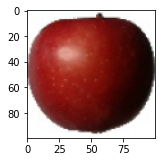

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(3,3,1)
ax1.imshow(np.array(Image.open("/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training/Apple Braeburn/101_100.jpg")))

In [6]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [7]:
print(train_set)
print(test_set)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: /kaggle/input/fruits/fruits-360_dataset/fruits-360/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: /kaggle/input/fruits/fruits-360_dataset/fruits-360/Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [8]:

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.Conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.b1_1 = nn.BatchNorm2d(64,momentum=0.1,affine=True)
        self.Conv2 = nn.Conv2d(64,64,   kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.b1_2 = nn.BatchNorm2d(64,momentum=0.1,affine=True)
        self.Conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b1_3  = nn.BatchNorm2d(128,momentum=0.1,affine=True)
        self.Conv4 = nn.Conv2d(128, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b1_4  = nn.BatchNorm2d(128,momentum=0.1,affine=True)
        

        self.Conv5 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b2_1 = nn.BatchNorm2d(256,momentum=0.1,affine=True)
        self.Conv6 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b2_2 = nn.BatchNorm2d(256,momentum=0.1,affine=True)
        self.Conv7= nn.Conv2d(256, 256,  kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b2_3 = nn.BatchNorm2d(256,momentum=0.1,affine=True)
        self.Conv8 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b2_4 = nn.BatchNorm2d(512,momentum=0.1,affine=True)

        self.Conv9 = nn.Conv2d(512, 512,  kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b3_1 = nn.BatchNorm2d(512,momentum=0.1,affine=True)
        self.Conv10 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b3_2 = nn.BatchNorm2d(512,momentum=0.1,affine=True)
        self.Conv11 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b3_3 = nn.BatchNorm2d(512,momentum=0.1,affine=True)
        self.Conv12 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b3_4 = nn.BatchNorm2d(512,momentum=0.1,affine=True)
        self.Conv13 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.b3_5 = nn.BatchNorm2d(512,momentum=0.1,affine=True)

        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2,dilation=(1,1),ceil_mode=False)

        self.FC1 = nn.Linear(25088,4096,bias=True)
        self.FC2 = nn.Linear(4096,4096,bias=True)
        self.FC3 = nn.Linear(4096,131,bias=True)

    def forward(self,out):
            out = F.relu(self.Conv1(out))
            out = F.relu(self.b1_1(out))
            out = F.relu(self.Conv2(out))
            out = F.relu(self.b1_2(out))
            out = self.maxPool(out)

            out = F.relu(self.Conv3(out))
            out = F.relu(self.b1_3(out))
            out = F.relu(self.Conv4(out))
            out = F.relu(self.b1_4(out))
            out = self.maxPool(out)

            out = F.relu(self.Conv5(out))
            out = F.relu(self.b2_1(out))
            out = F.relu(self.Conv6(out))
            out = F.relu(self.b2_2(out))
            out = F.relu(self.Conv7(out))
            out = F.relu(self.b2_3(out))
            out = self.maxPool(out)

            out = F.relu(self.Conv8(out))
            out = F.relu(self.b2_4(out))
            out = F.relu(self.Conv9(out))
            out = F.relu(self.b3_1(out))
            out = F.relu(self.Conv10(out))
            out = F.relu(self.b3_2(out))
            out = self.maxPool(out)

            out = F.relu(self.Conv11(out))
            out = F.relu(self.b3_3(out))
            out = F.relu(self.Conv12(out))
            out = F.relu(self.b3_4(out))
            out = F.relu(self.Conv13(out))
            out = F.relu(self.b3_5(out))
            out = self.maxPool(out)

            out = out.reshape(out.shape[0],-1)
            out = F.relu(self.FC1(out))
            out = F.dropout(out,0.5)
            out = F.relu(self.FC2(out))
            out = F.dropout(out,0.5)
            out = self.FC3(out)

            return out

In [9]:
model = VGG16()
model

VGG16(
  (Conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b1_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b2_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (b2_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [10]:
torch.cuda.empty_cache()

In [11]:
learning_rate = learning_rate
model = VGG16()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

In [12]:
total_step = len(train_loader)
print(total_step)

2116


images-size: torch.Size([32, 3, 224, 224])
out-size: torch.Size([3, 906, 1810])


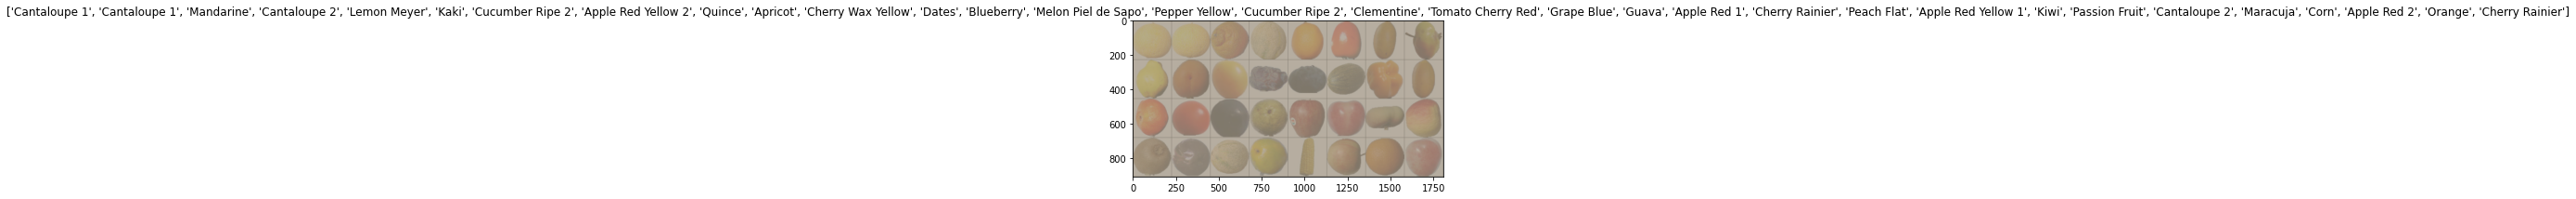

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_loader)) 
print("images-size:", images.shape)
out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_set.classes[x] for x in labels])
    

In [14]:
torch.cuda.empty_cache()

In [15]:
n_epochs = 3
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        torch.cuda.empty_cache()
        
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'vgg16-ML.pt')
            print('Improvement-Detected, save-model')


Epoch 1

Epoch [1/3], Step [0/2116], Loss: 4.9083
Epoch [1/3], Step [20/2116], Loss: 6.6700
Epoch [1/3], Step [40/2116], Loss: 5.3078
Epoch [1/3], Step [60/2116], Loss: 4.6979
Epoch [1/3], Step [80/2116], Loss: 4.5866
Epoch [1/3], Step [100/2116], Loss: 4.6571
Epoch [1/3], Step [120/2116], Loss: 4.5667
Epoch [1/3], Step [140/2116], Loss: 4.4276
Epoch [1/3], Step [160/2116], Loss: 4.1197
Epoch [1/3], Step [180/2116], Loss: 3.6214
Epoch [1/3], Step [200/2116], Loss: 3.8900
Epoch [1/3], Step [220/2116], Loss: 5.0258
Epoch [1/3], Step [240/2116], Loss: 2.8331
Epoch [1/3], Step [260/2116], Loss: 3.8687
Epoch [1/3], Step [280/2116], Loss: 3.4222
Epoch [1/3], Step [300/2116], Loss: 4.6789
Epoch [1/3], Step [320/2116], Loss: 3.6444
Epoch [1/3], Step [340/2116], Loss: 2.9590
Epoch [1/3], Step [360/2116], Loss: 3.8047
Epoch [1/3], Step [380/2116], Loss: 2.8870
Epoch [1/3], Step [400/2116], Loss: 1.8135
Epoch [1/3], Step [420/2116], Loss: 3.0534
Epoch [1/3], Step [440/2116], Loss: 2.4774
Epoch [1

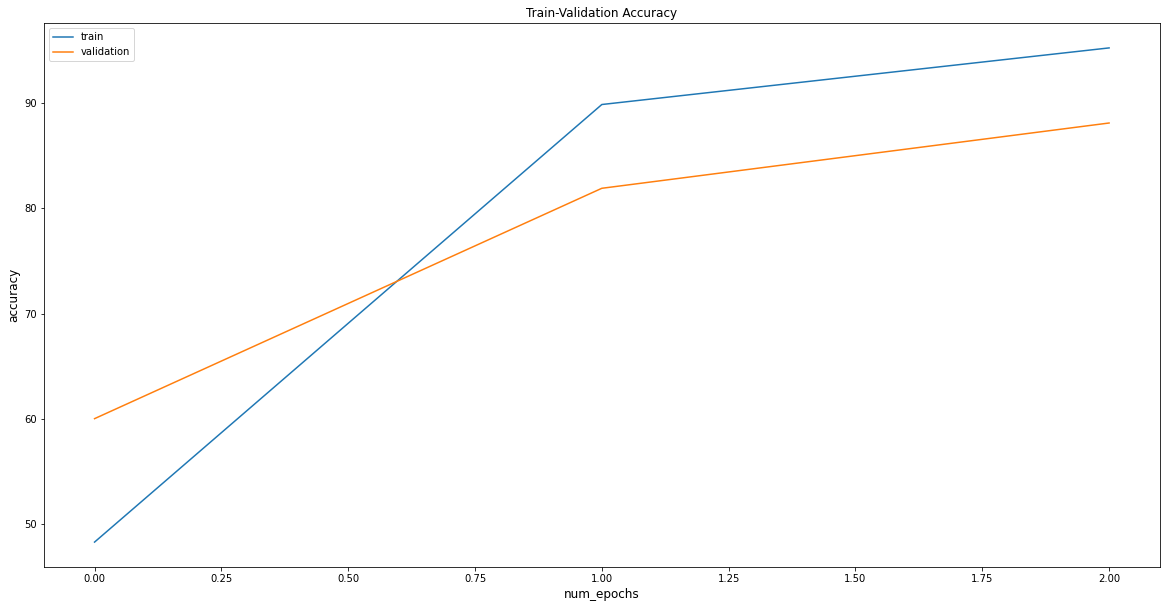

In [16]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')